# Consult IT - preliminary elimination
## Team members (*Fratelli*):
1. Wiktor Jakubowski
2. Luca Nowosielski

In [1]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, KBinsDiscretizer
from sklearn.cluster import AgglomerativeClustering

In [3]:
# load data
data = pd.read_excel('Baza_uczniów_CIT_2024.xlsx')
data.drop(['Imię', 'L.P.'], axis=1, inplace=True)

In [4]:
# check for missing values - there is none
data.isna().sum()

Płeć                     0
Wiek                     0
Język                    0
Poziom                   0
Hobby                    0
Typ prowadzenia zajęć    0
dtype: int64

In [20]:
### operations for categorical columns with order or binary values
ord_pipeline = Pipeline(steps=[
    ('encode', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
])

### operations for categorical unordered columns
cat_pipeline = Pipeline(steps=[
    ('encode', OneHotEncoder(handle_unknown='ignore'))
])

### operations for numerical columns
num_pipeline = Pipeline(steps=[
    ('discretize', KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform'))
])

# Column transformer
col_trans = ColumnTransformer(transformers=[
    ('ord_pipeline', ord_pipeline, ['Płeć', 'Typ prowadzenia zajęć', 'Poziom']),
    ('cat_pipeline', cat_pipeline, ['Język', 'Hobby']),
    ('num_pipeline', num_pipeline, ['Wiek'])
],
remainder='drop',
n_jobs=-1)

# hierarchical clustering at the end of the pipeline (limit as desired number of people in the group)
model_pipeline = Pipeline([
    ('preprocessing', col_trans),
    #('clustering', AgglomerativeClustering(metric='euclidean', linkage='ward'))
])

In [21]:
# preprocess data
data_preprocessed = model_pipeline.fit_transform(data)

# convert compressed data to numpy array
decompressed_data = data_preprocessed.toarray()


/home/lmn20/anaconda3/envs/consult_it_env/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


### Agglomerative clustering

In [25]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [54]:
import numpy as np

##### (a) Without constraint on the number of clusters

In [30]:
# initialise model
AC_model = AgglomerativeClustering(metric='euclidean', linkage='ward')

# fit model
clustered_data = AC_model.fit_predict(decompressed_data)

In [32]:
# Initialize TSNE model with desired parameters
tsne = TSNE(n_components=2, random_state=42)

# Perform t-SNE on the data
tsne_result = tsne.fit_transform(decompressed_data)

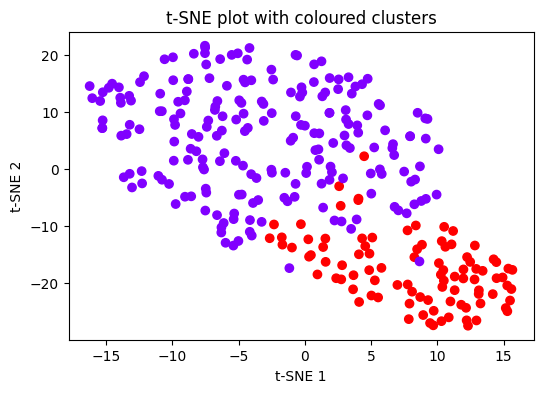

In [33]:
# t-SNE visualisation with separate colour by cluster

plt.figure(figsize=[6,4])

plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=clustered_data, cmap = 'rainbow')
plt.title('t-SNE plot with coloured clusters')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()

##### (b) With constraint on the number of clusters

In [34]:
# define model for 30 clusters of 300 observations
AC_model_30 = AgglomerativeClustering(n_clusters = 30, metric='euclidean', linkage='ward')

# fit model
clustered_data_30 = AC_model_30.fit_predict(decompressed_data)

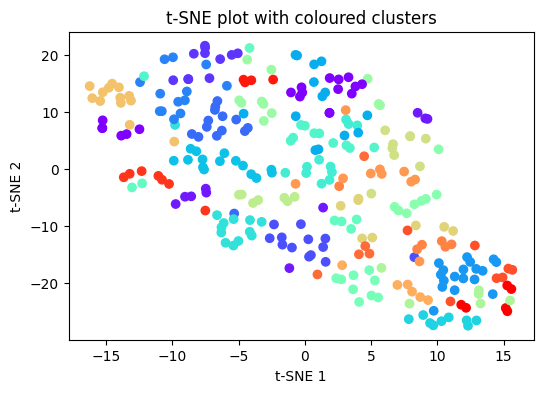

In [35]:
# t-SNE visualisation with separate colour by cluster

plt.figure(figsize=[6,4])

plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=clustered_data_30, cmap = 'rainbow')
plt.title('t-SNE plot with coloured clusters')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()

The cluster sizes are:  [19, 10, 11, 13, 14, 13, 18, 14, 15, 9, 13, 11, 11, 7, 9, 8, 11, 6, 7, 9, 8, 13, 6, 10, 6, 5, 7, 7, 4, 6]


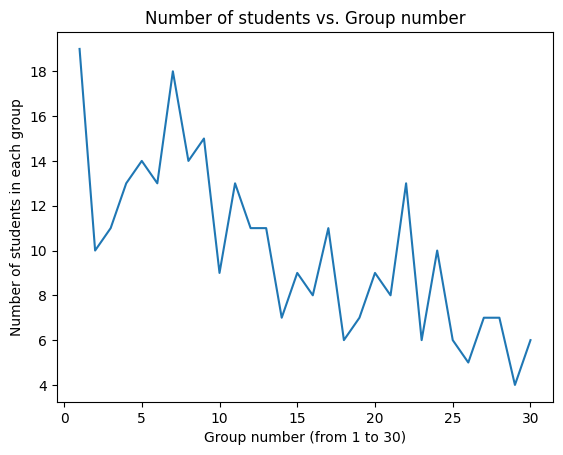

In [66]:
# check and plot the cluster sizes

cluster_sizes = []

# iterate over each of the 30 clusters
for i in range(30):
    
    cluster_sizes.append(clustered_data_30.tolist().count(i))

print('The cluster sizes are: ', cluster_sizes)

plt.plot(np.arange(1,31), cluster_sizes)
plt.xlabel('Group number (from 1 to 30)')
plt.ylabel('Number of students in each group')
plt.title('Number of students vs. Group number')
plt.show()

The cluster sizes have a clearly descending trend, the class sizes are not balanced. 
A hard limit to cluster sizes needs to be introduced, however it has the inherent risk of forcing some similar datapoints to be grouped in separate clusters with dissimilar datapoints

In [41]:
from sklearn.metrics import silhouette_score

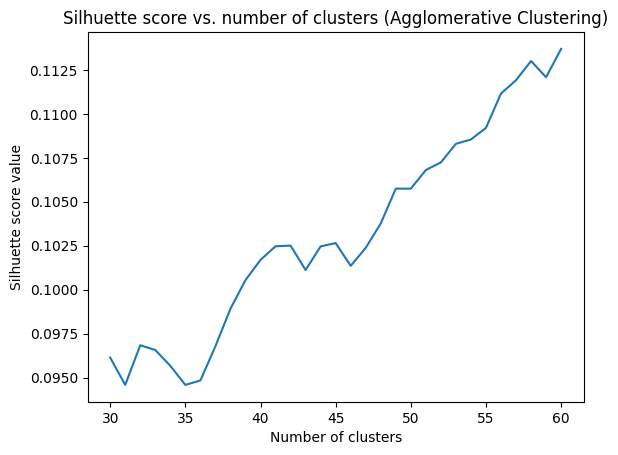

In [67]:
silhouette_list = []

for clusters in range(30, 61):

    # train the model for current number of clusters
    model = AgglomerativeClustering(n_clusters = clusters, 
                                    metric='euclidean', 
                                    linkage='ward')
    
    label = model.fit_predict(decompressed_data)

    silhouette_list.append(silhouette_score(decompressed_data, label))

#pd.DataFrame.from_dict({"Silhouette values": silhouette_list})

plt.plot(np.arange(30, 61), silhouette_list)
plt.xlabel('Number of clusters')
plt.ylabel('Silhuette score value')
plt.title('Silhuette score vs. number of clusters (Agglomerative Clustering)')
plt.show()

The silhouette score naturally increases, since smaller clusters would include a narrower range of datapoints with less variance. However, in a given range (of the number of clusters) a local maximum of the silhouette score can be picked for optimal clustering

In [ ]:
# implementation of agglomerative clustering with constraint on cluster sizes in this cell

### K-Means constrained

https://pypi.org/project/k-means-constrained/

Nice article about the algorithm: 

https://towardsdatascience.com/advanced-k-means-controlling-groups-sizes-and-selecting-features-a998df7e6745

In [72]:
from k_means_constrained import KMeansConstrained

# trial of KMeansConstrained with 40 clusters
kmc = KMeansConstrained(
     n_clusters=40,
     size_min=5,
     size_max=10,
     random_state=0
)
kmc.fit_predict(decompressed_data)

#print(kmc.cluster_centers_)
#print(kmc.labels_)

[[ 7.77777778e-01  0.00000000e+00  3.00000000e+00 ...  0.00000000e+00
   2.22222222e-01  1.88888889e+00]
 [ 7.00000000e-01  1.00000000e-01  1.00000000e-01 ...  6.93889390e-18
  -6.93889390e-18  8.00000000e-01]
 [ 4.28571429e-01  1.42857143e-01  1.57142857e+00 ...  0.00000000e+00
   1.42857143e-01  1.11022302e-16]
 ...
 [ 1.00000000e+00  2.00000000e-01  1.80000000e+00 ...  2.00000000e-01
   0.00000000e+00  1.80000000e+00]
 [ 8.00000000e-01  8.00000000e-01  1.40000000e+00 ...  6.93889390e-18
   0.00000000e+00  2.00000000e+00]
 [ 0.00000000e+00  8.00000000e-01  4.80000000e+00 ...  6.93889390e-18
   0.00000000e+00  1.40000000e+00]]
[12 33  7 15 29 13 13  9  3 15  2 12 32 14 11 36 26  1 19  0 37  2 18 36
 34 37 34 18 27 24 26 30 12 10  8 16 10  2  1  3 14 36 34 32  1 28  1 16
 24 34  6  3 31 38  6 24 39 19 39  6 14 36 38 20 10  9 27 21 31 15 16 36
 24  0 20  4 21 26 11 32 11 16 23 37 35  8  4 27 13 10 21  3  6  7 33 37
  5  0  7  0 30  7 31  8 36 34 10 34  6 14 11 16  8 14 11  4 23  3  3  5

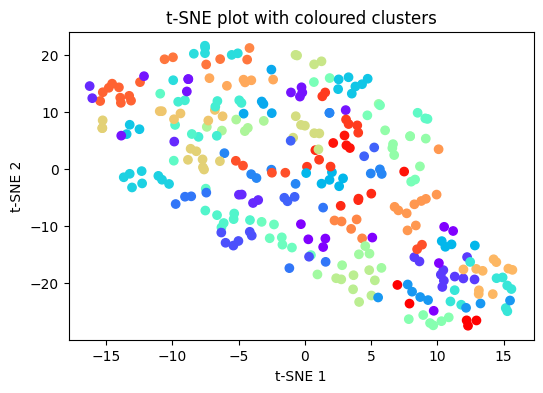

In [73]:
# t-SNE visualisation with separate colour by cluster

plt.figure(figsize=[6,4])

plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=kmc.labels_, cmap = 'rainbow')
plt.title('t-SNE plot with coloured clusters')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()

The cluster sizes are:  [9, 10, 7, 10, 7, 6, 7, 10, 8, 5, 10, 10, 8, 7, 10, 8, 9, 6, 7, 6, 6, 9, 6, 6, 8, 5, 6, 10, 7, 10, 6, 10, 6, 5, 10, 6, 9, 5, 5, 5]


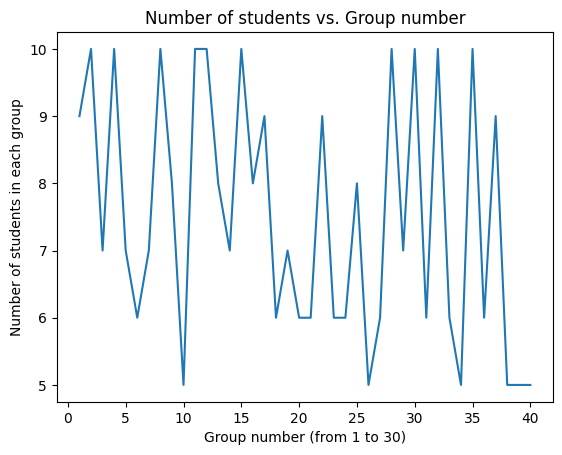

In [94]:
# check and plot the cluster sizes

cluster_sizes = []

# iterate over each of the 40 clusters
for i in range(40):
    
    cluster_sizes.append(kmc.labels_.tolist().count(i))

print('The cluster sizes are: ', cluster_sizes)

plt.plot(np.arange(1,41), cluster_sizes)
plt.xlabel('Group number (from 1 to 30)')
plt.ylabel('Number of students in each group')
plt.title('Number of students vs. Group number')
plt.show()

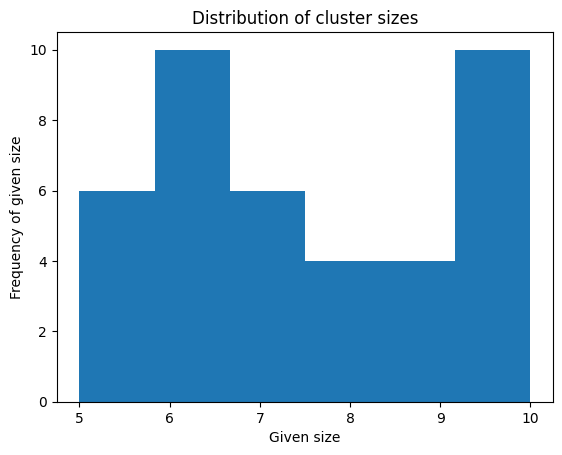

In [102]:
# plot the distribution of cluster sizes

plt.hist(cluster_sizes, bins=6)
plt.ylabel('Frequency of given size')
plt.xlabel('Given size')
plt.title('Distribution of cluster sizes')
plt.show()

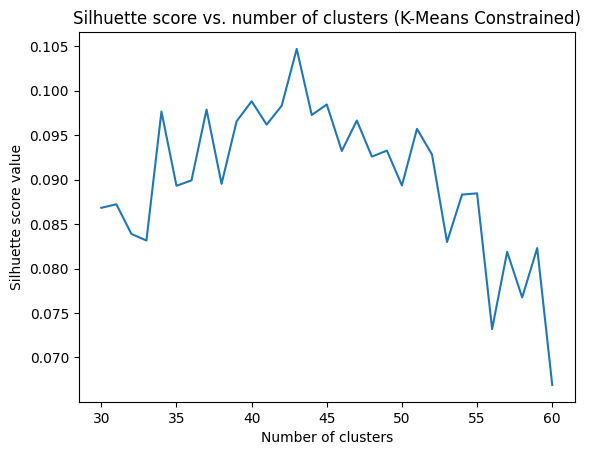

In [105]:
# plot silhouette score vs. number of clusters between 30 and 60

silhouette_list = []

for clusters in range(30, 61):

    # train the model for current number of clusters
    kmc = KMeansConstrained(
     n_clusters=clusters,
     size_min=5,
     size_max=10,
     random_state=0
    )

    label = kmc.fit_predict(decompressed_data)

    # append the silhouette score to the silhouette_list
    silhouette_list.append(silhouette_score(decompressed_data, label))

#pd.DataFrame.from_dict({"Silhouette values": silhouette_list})

plt.plot(np.arange(30, 61), silhouette_list)
plt.xlabel('Number of clusters')
plt.ylabel('Silhuette score value')
plt.title('Silhuette score vs. number of clusters (K-Means Constrained)')
plt.show()

In [109]:
# check which number of clusters maximises the silhouette score

for i in range(31):

    if silhouette_list[i] == np.array(silhouette_list).max():

        print("The optimal number of clusters is: ", i + 30)

The optimal number of clusters is:  43


Let's run and analyse the optimal model below

In [110]:
# run the model that maximises the silhouette score (n_clusters=43)

kmc = KMeansConstrained(
     n_clusters=43,
     size_min=5,
     size_max=10,
     random_state=0
)
kmc.fit_predict(decompressed_data)

#print(kmc.cluster_centers_)
#print(kmc.labels_)

array([23, 17,  4, 10, 15, 17,  6, 25,  9, 21, 41, 23, 17, 42, 18, 31, 13,
       27, 18, 32,  5, 38, 24, 27, 30, 35,  6, 11, 19, 34, 13, 28, 23,  7,
       26,  6,  0, 30, 31, 12, 15, 31, 41,  5, 27, 25, 41, 22, 34, 41,  9,
        0, 14, 13,  3, 38, 20,  5, 20,  9, 42, 31, 13, 20,  7,  8, 19,  2,
       14, 10, 22,  7, 34, 39, 16, 11,  4, 13, 40,  5, 18, 21,  1, 35, 29,
       42, 37, 40, 17,  0,  8, 12,  3,  4, 17, 35,  2, 16,  4, 11, 28, 29,
       14, 42, 27, 41,  7, 41,  3, 26, 40, 22, 26, 42, 18, 24, 21,  9, 12,
       38,  4, 34, 29,  2, 40, 22, 15, 36, 41, 22, 11, 32, 32, 35, 31, 34,
        1, 41,  7, 33, 13, 29, 17, 22, 17,  6, 11, 36, 24,  3, 20, 38, 12,
       25, 42, 29,  8,  5,  0, 21,  1, 15, 30, 28, 19,  6, 15, 12, 24, 14,
       33, 16, 28, 34, 33,  4, 12, 36, 10, 13, 27,  8,  0,  4, 23, 21, 16,
       32, 33, 10, 40, 21, 23, 36,  0, 25, 16, 23, 42, 19, 40, 13, 38, 18,
        7, 37,  1, 17,  9, 41, 32, 37, 19, 12,  7, 16, 17, 27, 31, 24, 23,
       26, 25,  4, 11, 33

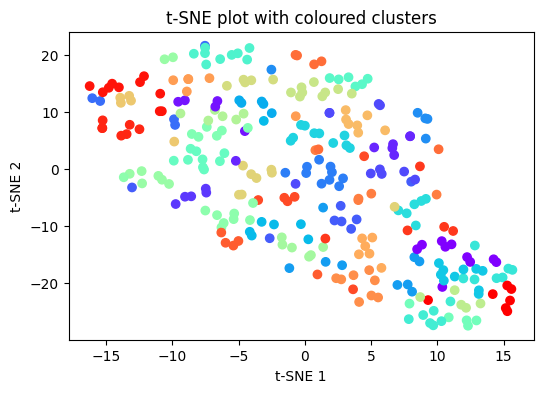

In [111]:
# t-SNE visualisation of optimal clustering with separate colour by cluster

plt.figure(figsize=[6,4])

plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=kmc.labels_, cmap = 'rainbow')
plt.title('t-SNE plot with coloured clusters')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()

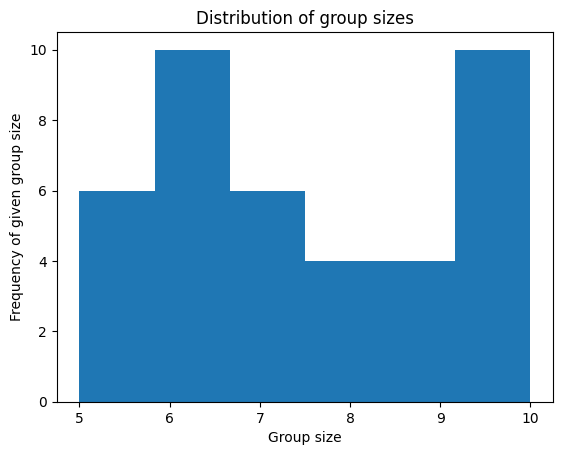

In [112]:
# plot the distribution of cluster sizes

plt.hist(cluster_sizes, bins=6)
plt.ylabel('Frequency of given group size')
plt.xlabel('Group size')
plt.title('Distribution of group sizes')
plt.show()